In [74]:
!pip install numpy
!pip install seaborn
!pip install scipy
!pip install scikit-learn

In [75]:
pip install scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [108]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd
import h5py

In [109]:
#Link to file: 
#https://springernature.figshare.com/collections/A_database_of_high-density_surface_electromyogram_signals_comprising_65_hand_gestures_performed_in_an_isometric_manner/5090861/1
EMG_file_name='/Users/mariannecivitardevol/Documents/EPFL/Masters/neural_signals/subj1_relevant_vars.mat'

data = loadmat(EMG_file_name)
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Fs', 'adjusted_class_new', 'adjusted_repetition_new', 'emg_flexors_new'])


In [110]:
fs = np.array(data["Fs"])[0][0] # Sampling frequency (Hz)
print(fs)


2048


(1000000, 8, 8)
(1000000, 64)


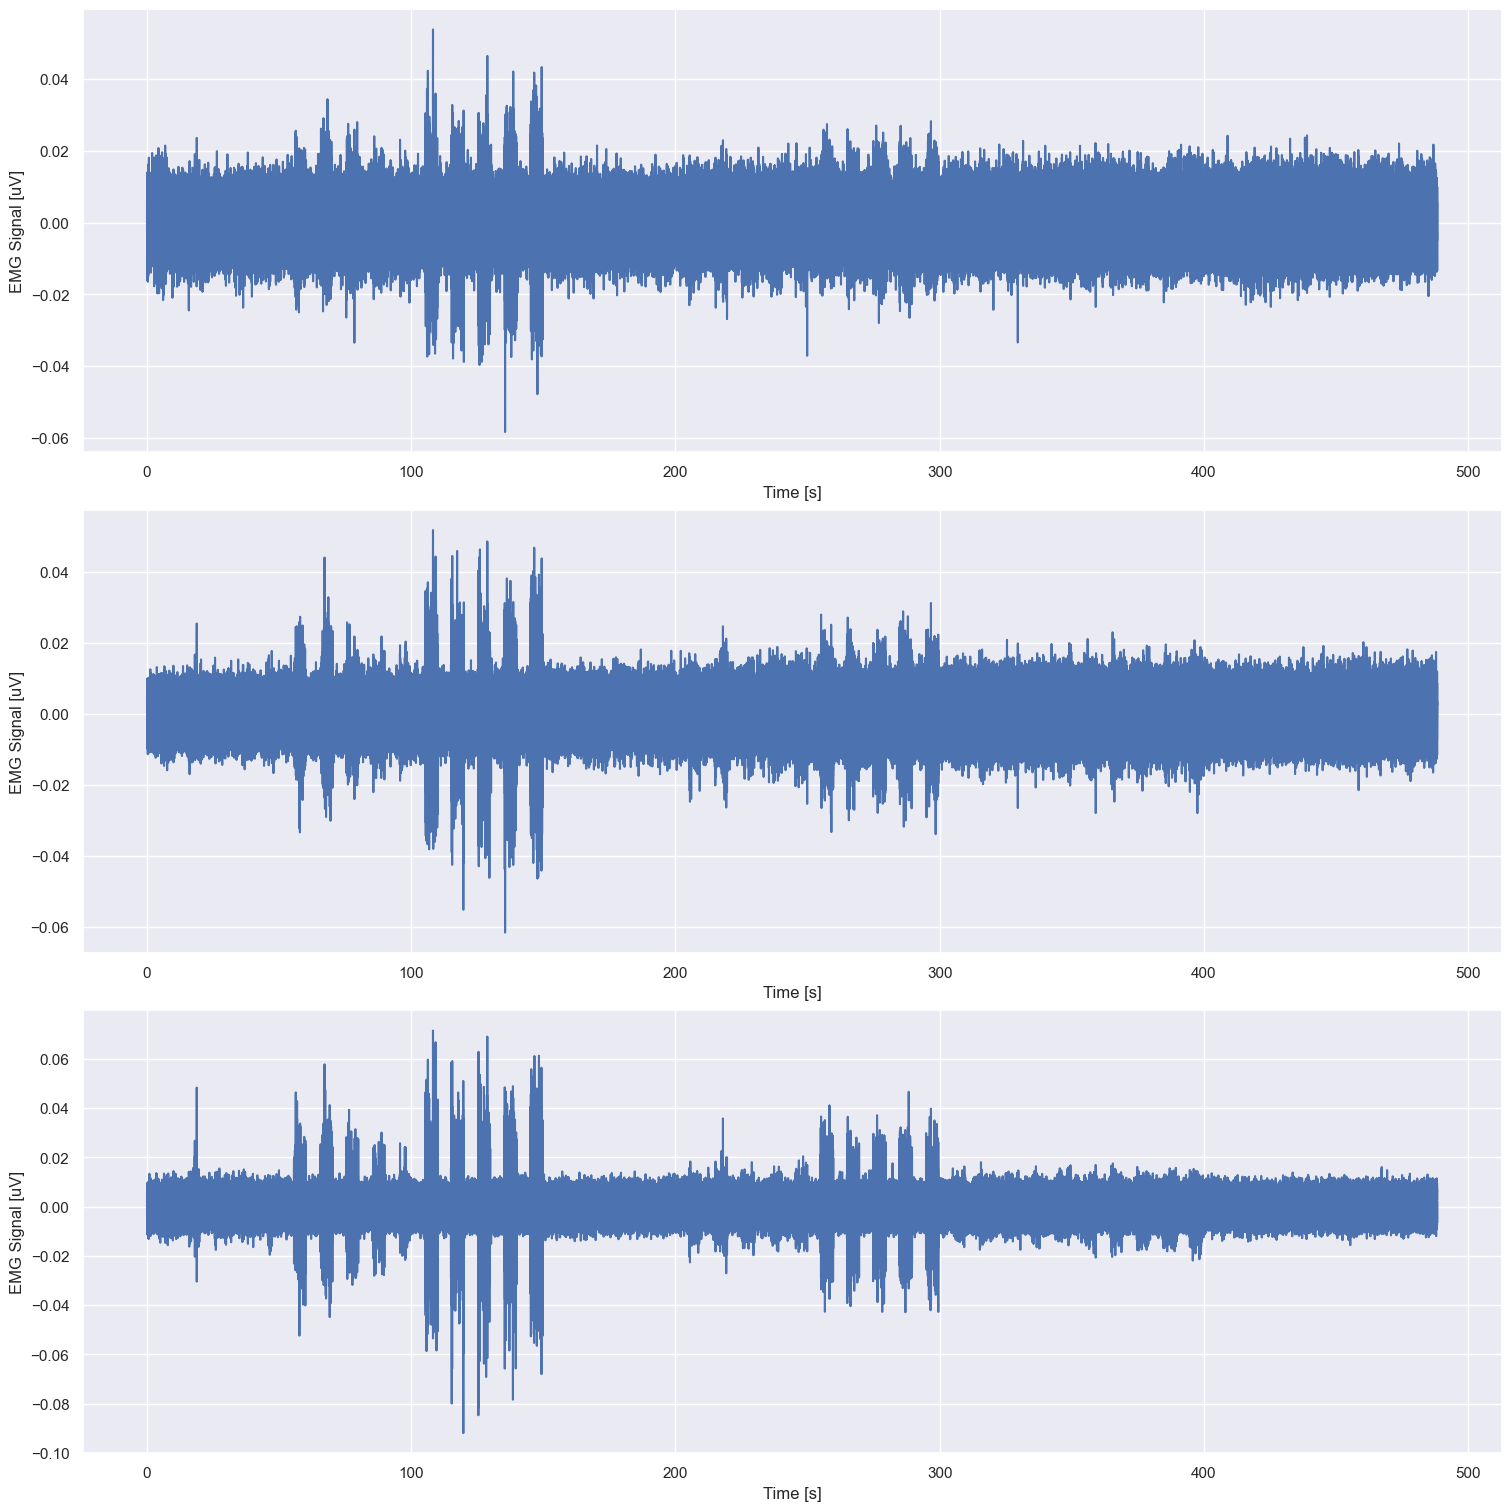

In [111]:
n_datapoints = 1000000
n_channels = 64


'''
emg_extensors = np.array(data["emg_extensors"][:,:,:n_datapoints])
emg_flexors = np.array(data["emg_flexors"][:,:,:n_datapoints])
emg_extensors = np.reshape(emg_extensors, (int(n_channels/2), n_datapoints))
emg_flexors = np.reshape(emg_flexors, (int(n_channels/2), n_datapoints))
print(emg_extensors.shape)
print(emg_extensors.shape)
emg = np.concatenate((emg_flexors, emg_extensors), axis=0)
'''
emg = np.array(data["emg_flexors_new"][:n_datapoints,:,:])
print(emg.shape)
emg = np.reshape(emg, (n_datapoints, n_channels))
print(emg.shape)

n2plot = 3
tsteps = np.arange(0,emg.shape[0]/fs, 1/fs) #Time vector for plotting

fig, ax = plt.subplots(n2plot, 1, constrained_layout=True, figsize=(15, 15))
for i in range(n2plot):
    ax[i].plot(tsteps, emg[:,i])
    ax[i].set_xlabel("Time [s]")
    ax[i].set_ylabel("EMG Signal [uV]") 

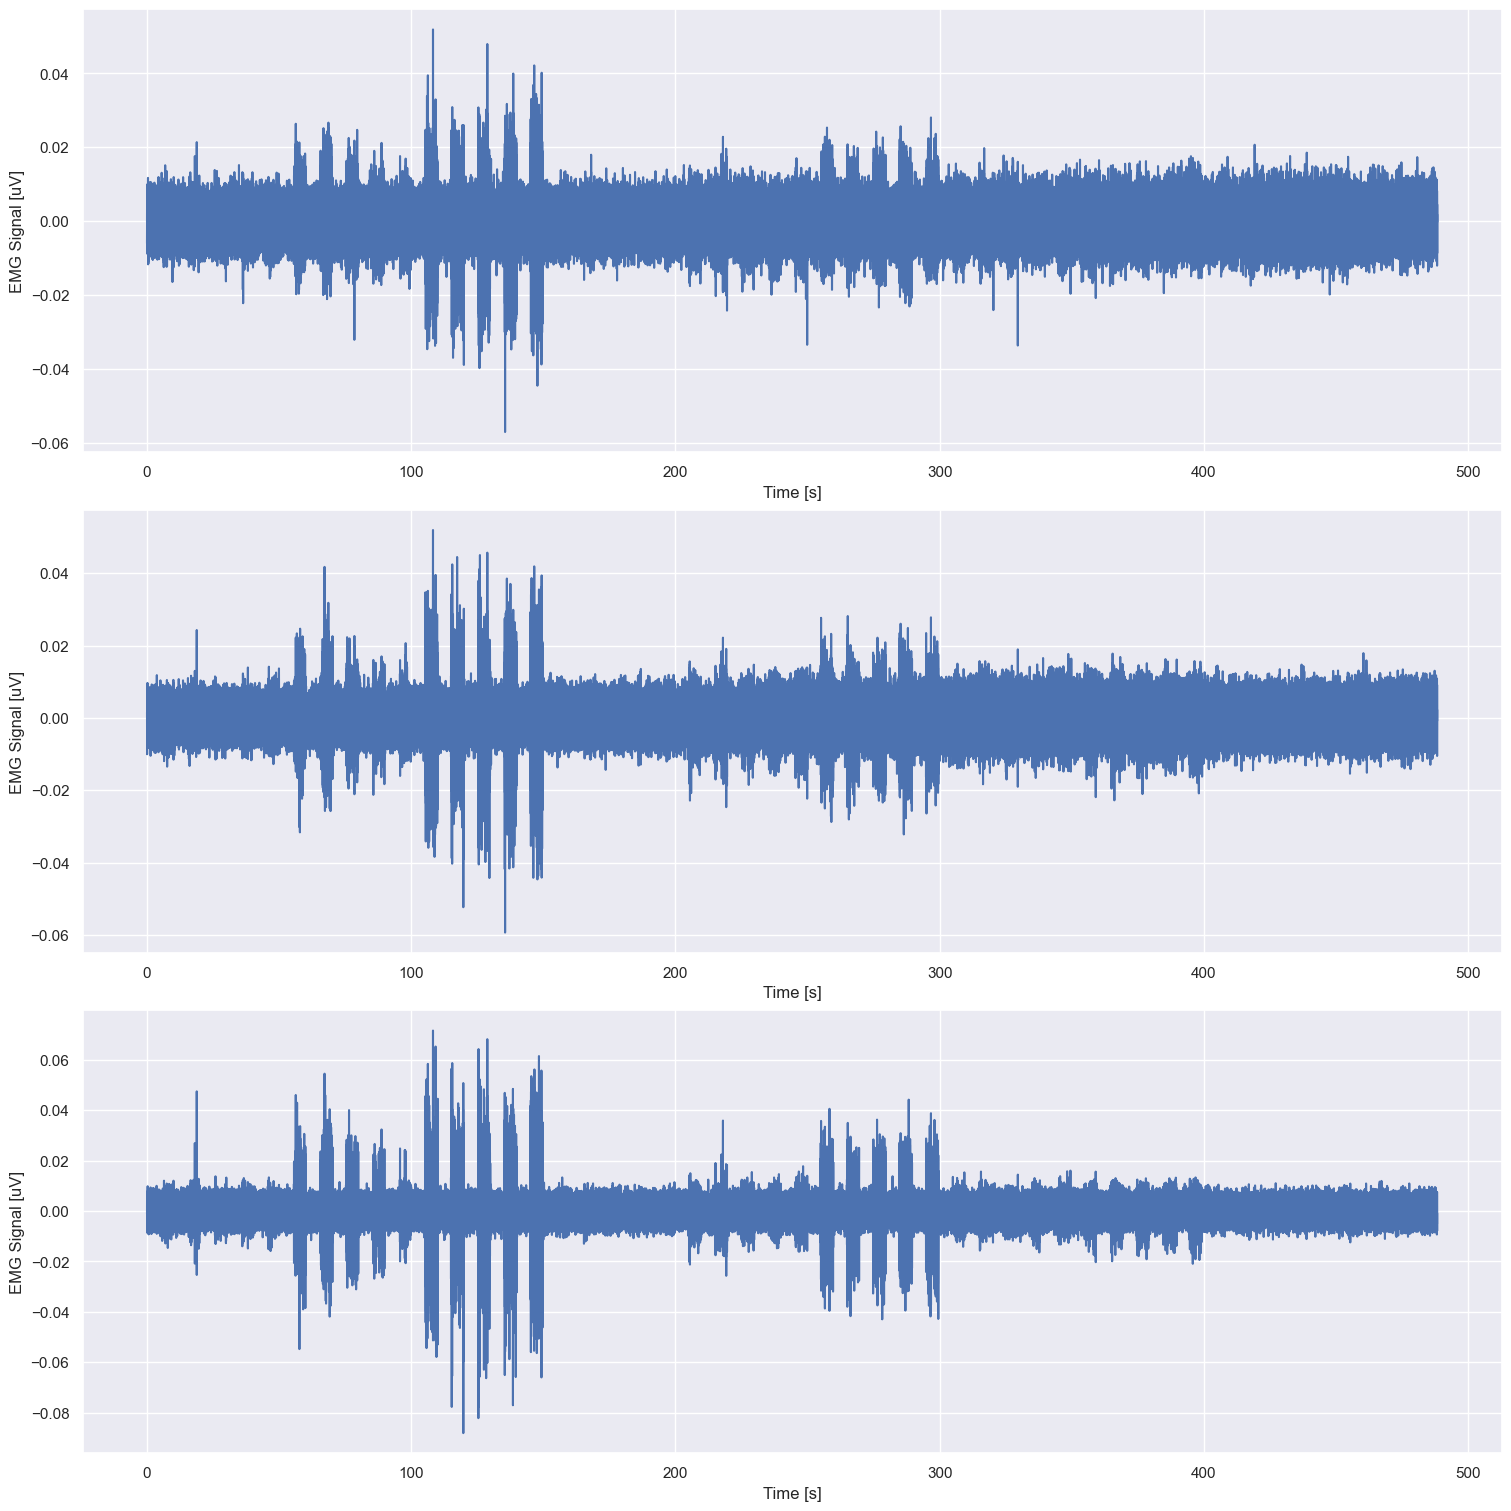

In [112]:
Wn = (5, 500) 
sos = butter(N=4, Wn=Wn, fs=fs, btype="bandpass", output="sos") 
emg_filtered = sosfiltfilt(sos, emg.T).T 

#Already filtered?
'''
Wns = [n*50 for n in range(1,11)] # removing 50Hz noise and its harmonics

for Wn in Wns:
    sos = butter(N=4, Wn=(Wn - 0.5, Wn + 0.5), fs=fs, btype="bandstop", output="sos")
    emg_filtered = sosfiltfilt(sos, emg_filtered.T).T
'''
fig, ax = plt.subplots(n2plot, 1, constrained_layout=True, figsize=(15, 15))
for i in range(n2plot):
    ax[i].plot(tsteps, emg_filtered[:,i])
    ax[i].set_xlabel("Time [s]")
    ax[i].set_ylabel("EMG Signal [uV]")

Text(0.5, 1.0, 'Log scale for y-axis')

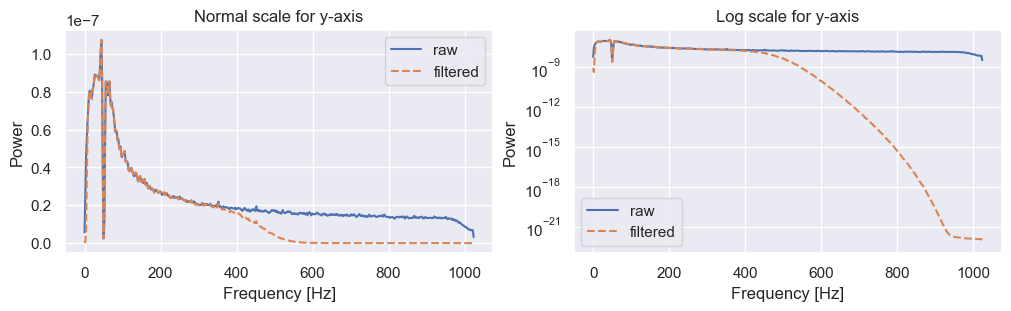

In [113]:
#Use Welch's method for power spectral density estimation, it reduces the variance of the estimate.
freqs_pre, Pxx_pre = welch(emg[:, 0], fs=fs, nperseg=1064)
freqs_post, Pxx_post = welch(emg_filtered[:, 0],fs = fs,  nperseg=1064)

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3))
ax[0].plot(freqs_pre, Pxx_pre, label="raw")
ax[0].plot(freqs_post, Pxx_post, linestyle="--", label="filtered")
ax[0].legend()
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Power")
ax[0].set_title("Normal scale for y-axis")

ax[1].semilogy(freqs_pre, Pxx_pre, label="raw")
ax[1].semilogy(freqs_post, Pxx_post, linestyle="--", label="filtered")
ax[1].legend()
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Power")
ax[1].set_title("Log scale for y-axis")

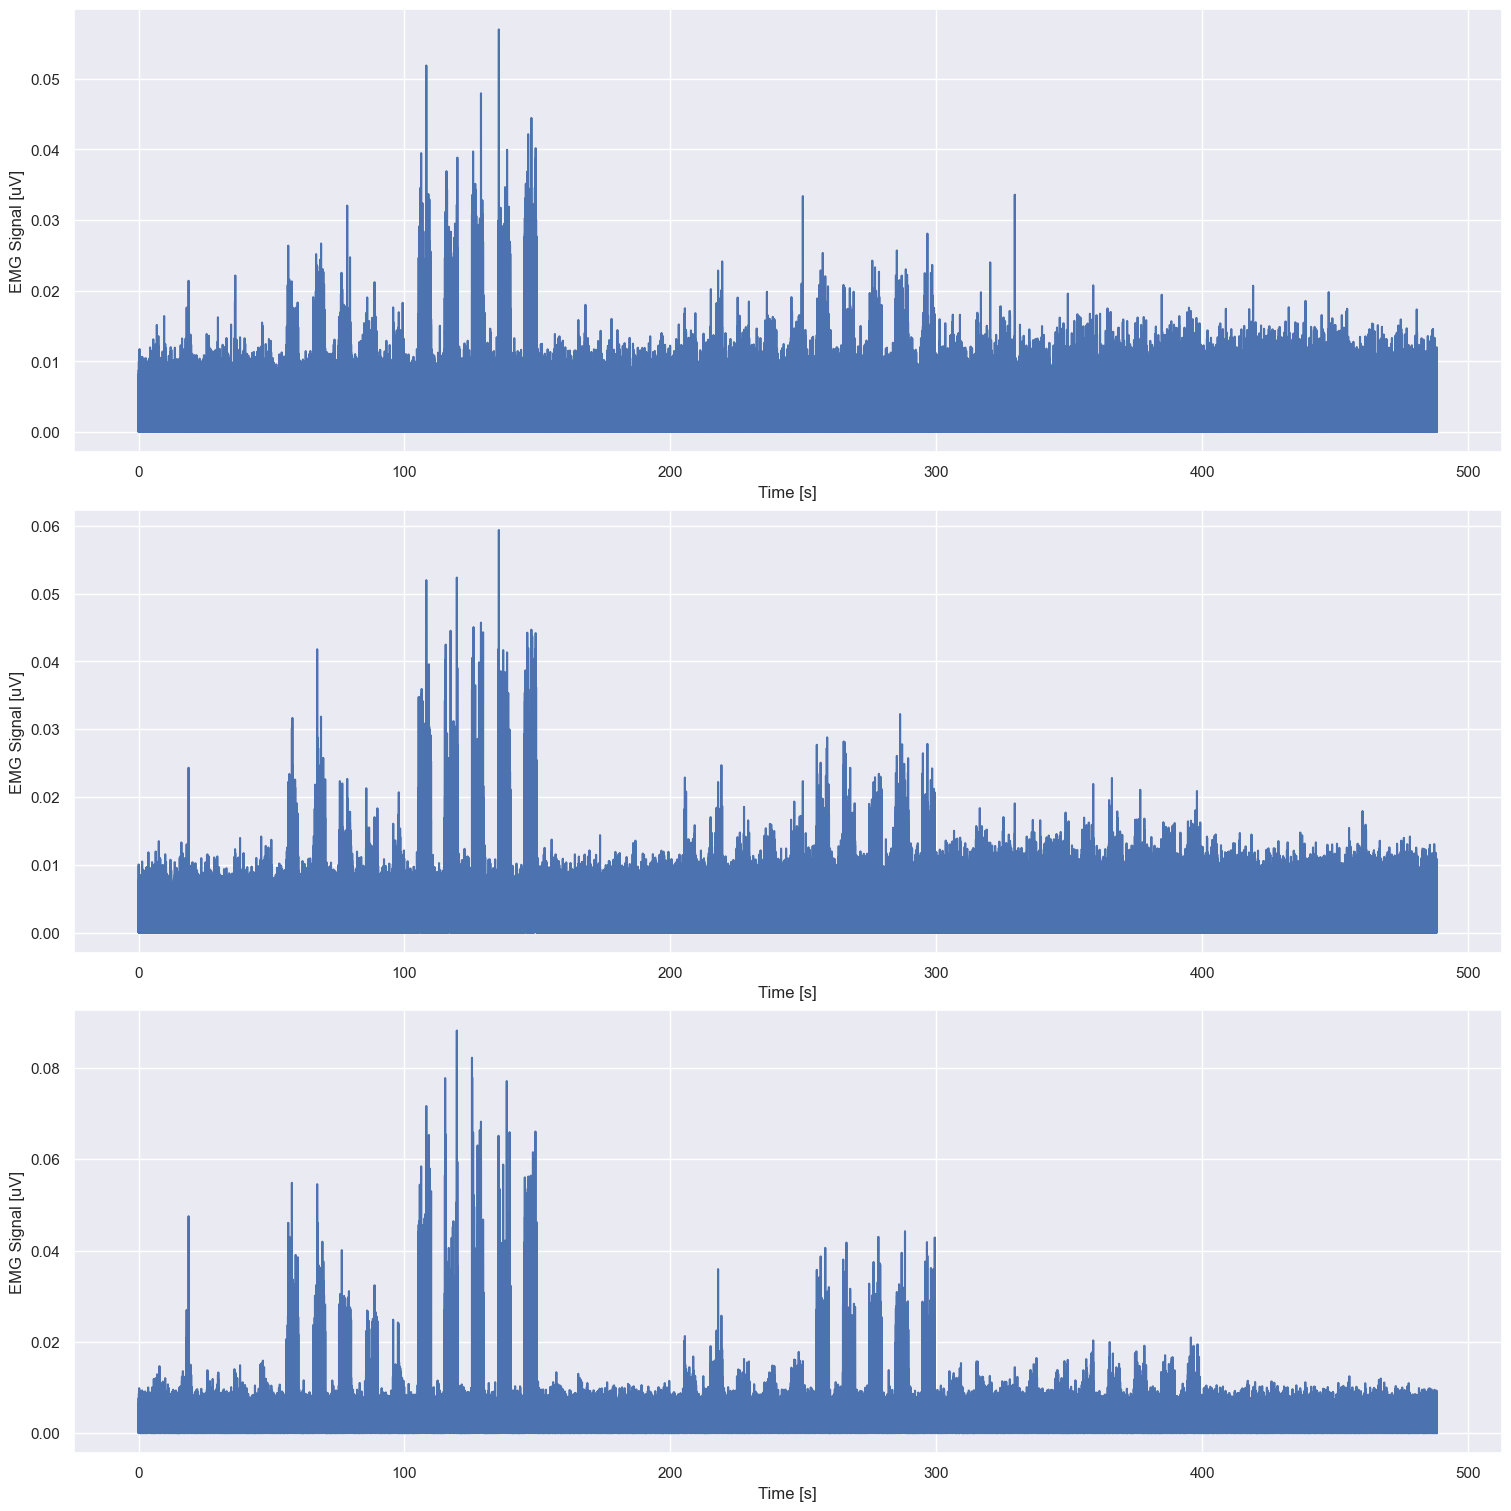

In [114]:
emg_rectified = np.abs(emg_filtered) # Rectify the signal

fig, ax = plt.subplots(n2plot, 1, constrained_layout=True, figsize=(15, 15))
for i in range(n2plot):
    ax[i].plot(tsteps, emg_rectified[:, i])
    ax[i].set_xlabel("Time [s]")
    ax[i].set_ylabel("EMG Signal [uV]")

Text(0.5, 0.98, 'EMG envelopes')

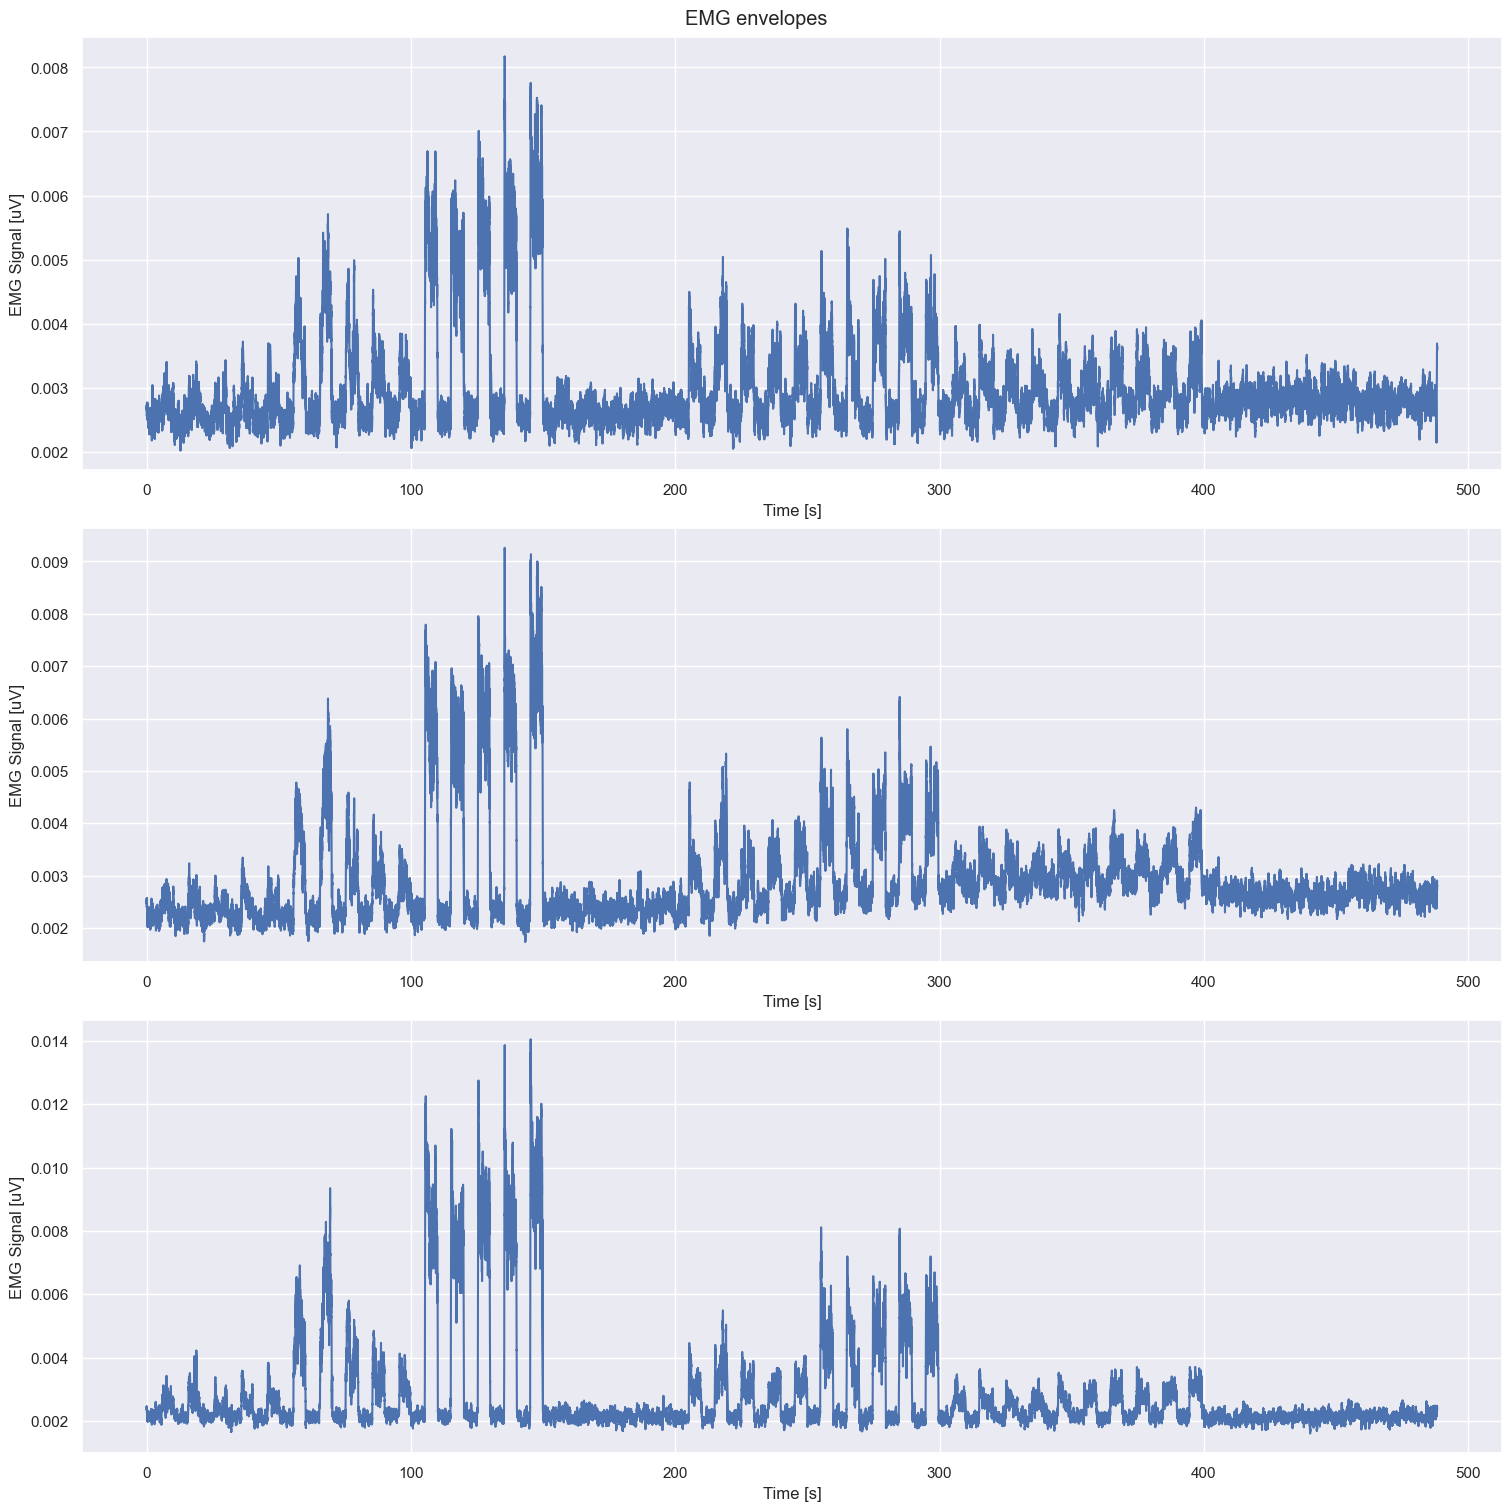

In [115]:
mov_mean_size = 400
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size
emg_envelopes = convolve1d(emg_rectified, weights=mov_mean_weights, axis=0) # convolve1d the rectified signal with the moving average weights


fig, ax = plt.subplots(n2plot, 1, constrained_layout=True, figsize=(15, 15))
for i in range(n2plot):
    ax[i].plot(tsteps, emg_envelopes[:, i])
    ax[i].set_xlabel("Time [s]")
    ax[i].set_ylabel("EMG Signal [uV]")
plt.suptitle("EMG envelopes")

In [116]:
compression = 2
emg_envelopes = emg_envelopes[::2, :]
emg_envelopes.shape
emg_envelopes_forSubsets= emg_envelopes

In [85]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=3, init="nndsvda", max_iter=500)

In [86]:
W = nmf.fit_transform(emg_envelopes)
H = nmf.components_

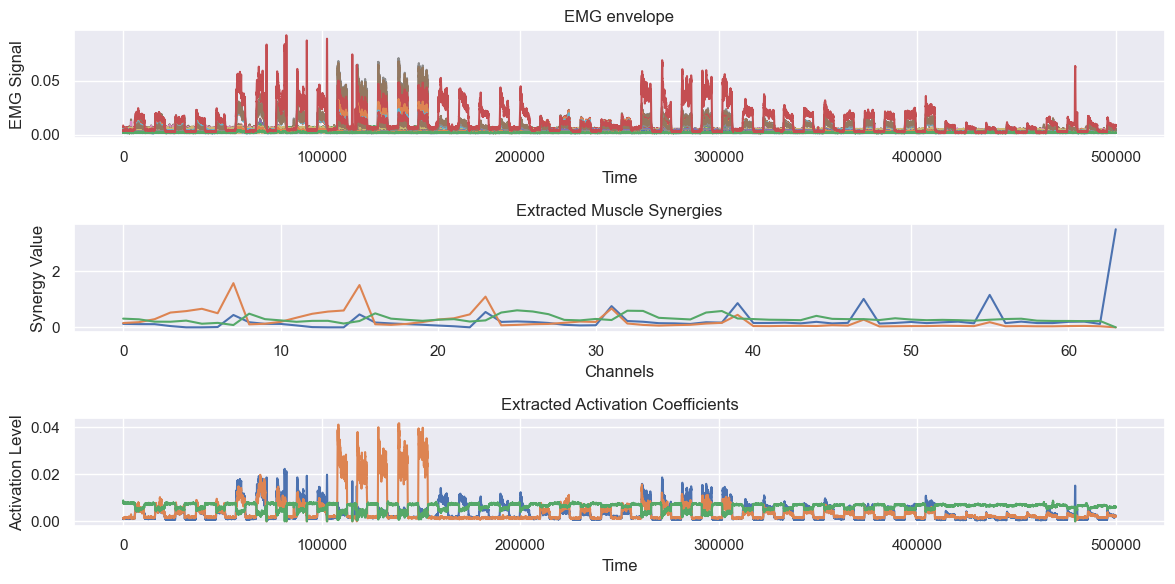

In [87]:
# Plot synthetic EMG data
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(emg_envelopes)
plt.title('EMG envelope')
plt.xlabel('Time')
plt.ylabel('EMG Signal')

# Plot extracted synergies
plt.subplot(3, 1, 2)
plt.plot(H.T)
plt.title('Extracted Muscle Synergies')
plt.xlabel('Channels')
plt.ylabel('Synergy Value')

# Plot extracted activation coefficients
plt.subplot(3, 1, 3)
plt.plot(W)
plt.title('Extracted Activation Coefficients')
plt.xlabel('Time')
plt.ylabel('Activation Level')

plt.tight_layout()

In [88]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

In [89]:
W = pca.fit_transform(emg_envelopes)
H = pca.components_

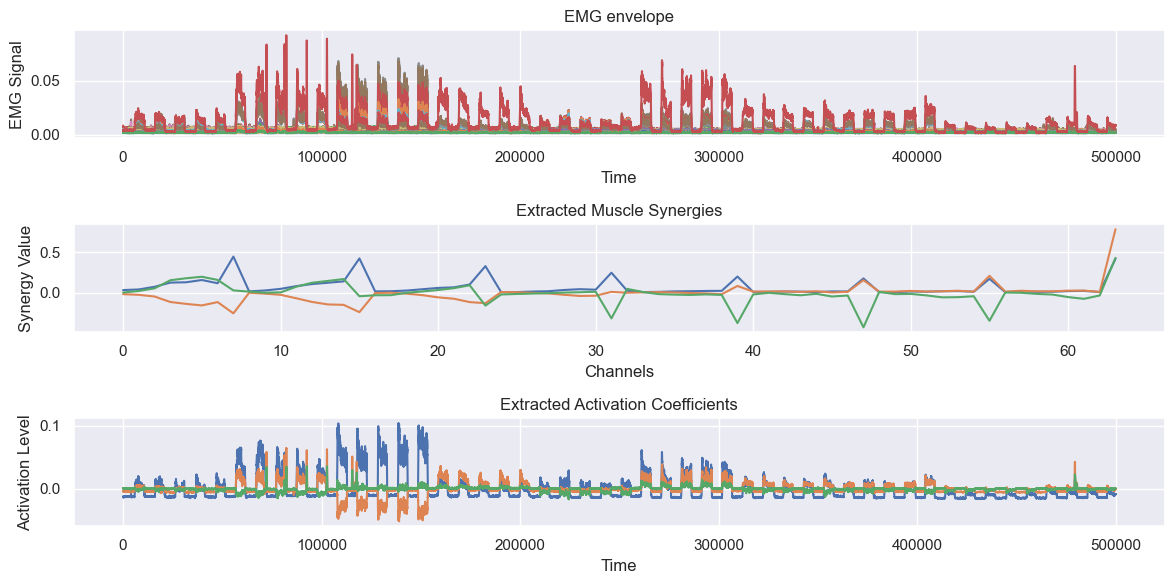

In [90]:
# Plot synthetic EMG data
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(emg_envelopes)
plt.title('EMG envelope')
plt.xlabel('Time')
plt.ylabel('EMG Signal')

# Plot extracted synergies
plt.subplot(3, 1, 2)
plt.plot(H.T)
plt.title('Extracted Muscle Synergies')
plt.xlabel('Channels')
plt.ylabel('Synergy Value')

# Plot extracted activation coefficients
plt.subplot(3, 1, 3)
plt.plot(W)
plt.title('Extracted Activation Coefficients')
plt.xlabel('Time')
plt.ylabel('Activation Level')

plt.tight_layout()

In [91]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components=3)
W = ica.fit_transform(emg_envelopes)
H = ica.components_

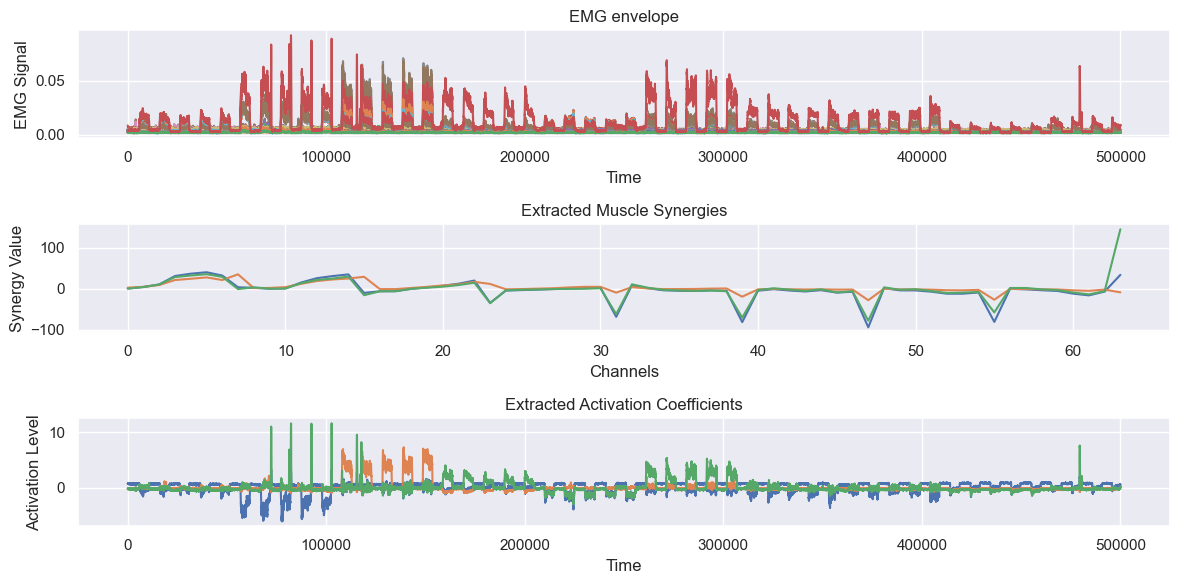

In [92]:
# Plot synthetic EMG data
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(emg_envelopes)
plt.title('EMG envelope')
plt.xlabel('Time')
plt.ylabel('EMG Signal')

# Plot extracted synergies
plt.subplot(3, 1, 2)
plt.plot(H.T)
plt.title('Extracted Muscle Synergies')
plt.xlabel('Channels')
plt.ylabel('Synergy Value')

# Plot extracted activation coefficients
plt.subplot(3, 1, 3)
plt.plot(W)
plt.title('Extracted Activation Coefficients')
plt.xlabel('Time')
plt.ylabel('Activation Level')

plt.tight_layout()

In [93]:
reconstruction_err = np.zeros(9)

# we will do NMF with 2 to 10 components
for i in range(9):
    print("Running NMF with {} components".format(i + 2))
          
    nmf = NMF(n_components=(i + 2))#, max_iter=500)

    nmf.fit(emg_envelopes)
    reconstruction_err[i] = nmf.reconstruction_err_

Running NMF with 2 components


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Running NMF with 3 components
Running NMF with 4 components


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Running NMF with 5 components


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Running NMF with 6 components


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Running NMF with 7 components


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Running NMF with 8 components


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Running NMF with 9 components


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Running NMF with 10 components


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


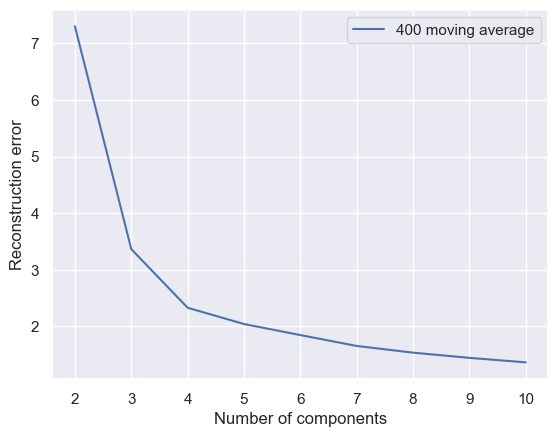

In [94]:
fig, ax = plt.subplots()
ax.plot(np.arange(2, 11), reconstruction_err, label="400 moving average")
#ax.plot(np.arange(2, 11), reconstruction_err_100, label="100 moving average")
ax.set_xlabel("Number of components")
ax.set_ylabel("Reconstruction error")
ax.legend()

### Compute the spatial synergies corresponding to different subsets of the data samples. Are the synergies stable across the different subsets?

### - Take a subset of the data :

In [117]:
#we want 3 subsets:
print(emg_envelopes_forSubsets.shape[0])
nb_per_subset = (emg_envelopes_forSubsets.shape[0]) / 3
nb_per_subset = int(nb_per_subset)
print(nb_per_subset)
subset_1 = emg_envelopes_forSubsets[:nb_per_subset, :]
subset_2 = emg_envelopes_forSubsets[nb_per_subset:2*nb_per_subset,:]
subset_3 = emg_envelopes_forSubsets[nb_per_subset*2:3*nb_per_subset,:]
print(subset_3.shape)

500000
166666
(166666, 64)


### - Compute spatial synergies :

In [118]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=5, init="nndsvda", max_iter=500)

In [119]:
subset_1_NMF = subset_1
subset_2_NMF = subset_2
subset_3_NMF = subset_3

In [120]:

W1= nmf.fit_transform(subset_1_NMF)
H1_NMF = nmf.components_

W2= nmf.fit_transform(subset_2_NMF)
H2_NMF = nmf.components_

W3= nmf.fit_transform(subset_3_NMF)
H3_NMF = nmf.components_

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


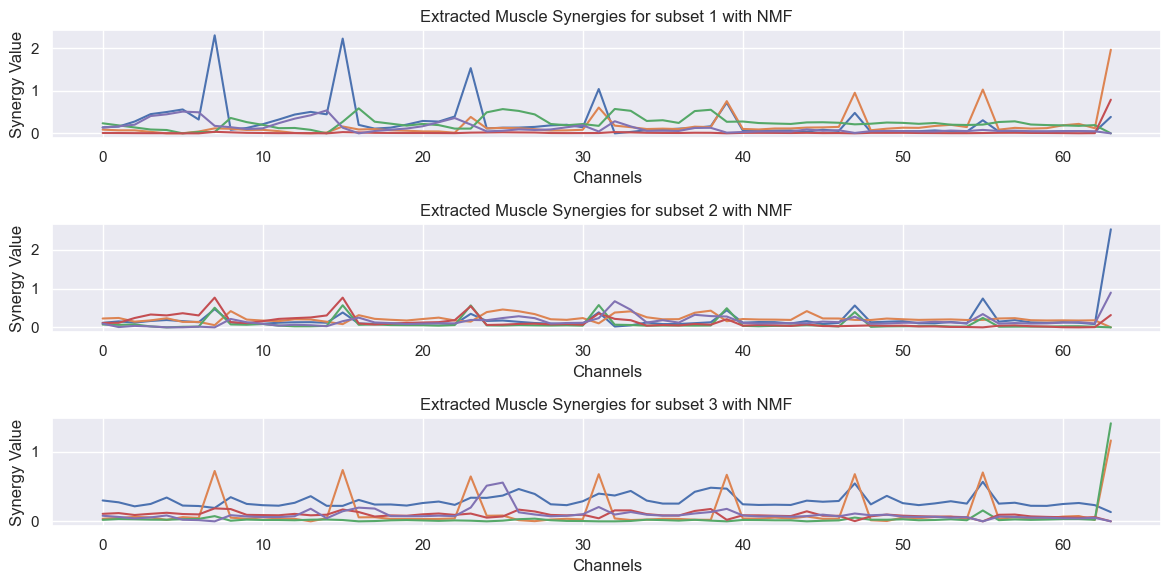

In [121]:
# Plot extracted synergies
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(H1_NMF.T)
plt.title('Extracted Muscle Synergies for subset 1 with NMF')
plt.xlabel('Channels')
plt.ylabel('Synergy Value')

plt.subplot(3, 1, 2)
plt.plot(H2_NMF.T)
plt.title('Extracted Muscle Synergies for subset 2 with NMF')
plt.xlabel('Channels')
plt.ylabel('Synergy Value')

plt.subplot(3, 1, 3)
plt.plot(H3_NMF.T)
plt.title('Extracted Muscle Synergies for subset 3 with NMF')
plt.xlabel('Channels')
plt.ylabel('Synergy Value')

plt.tight_layout()
plt.savefig('NMF')

In [122]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)

In [123]:
subset_1_PCA = subset_1
subset_2_PCA = subset_2
subset_3_PCA = subset_3

In [124]:
W1= pca.fit_transform(subset_1_PCA)
H1_PCA = pca.components_

W2= pca.fit_transform(subset_2_PCA)
H2_PCA = pca.components_

W3= pca.fit_transform(subset_3_PCA)
H3_PCA = pca.components_

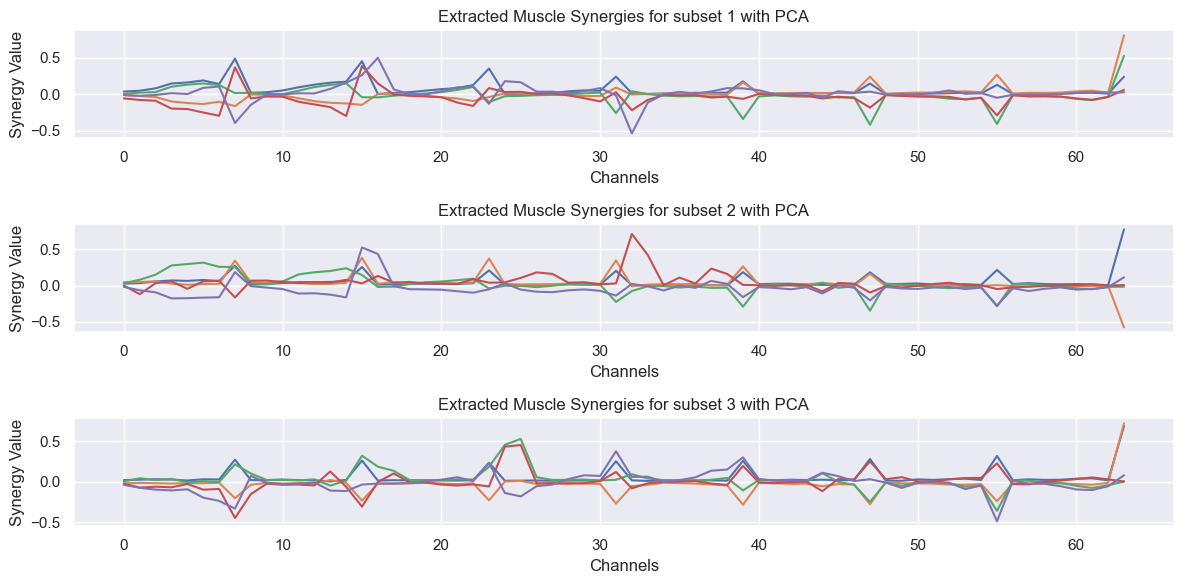

In [125]:
# Plot extracted synergies
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(H1_PCA.T)
plt.title('Extracted Muscle Synergies for subset 1 with PCA')
plt.xlabel('Channels')
plt.ylabel('Synergy Value')

plt.subplot(3, 1, 2)
plt.plot(H2_PCA.T)
plt.title('Extracted Muscle Synergies for subset 2 with PCA')
plt.xlabel('Channels')
plt.ylabel('Synergy Value')

plt.subplot(3, 1, 3)
plt.plot(H3_PCA.T)
plt.title('Extracted Muscle Synergies for subset 3 with PCA')
plt.xlabel('Channels')
plt.ylabel('Synergy Value')

plt.tight_layout()
plt.savefig('PCA')

In [126]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components=5)

In [127]:
subset_1_ICA = subset_1
subset_2_ICA = subset_2
subset_3_ICA = subset_3

In [128]:
W1= ica.fit_transform(subset_1_ICA)
H1_ICA = ica.components_

W2= ica.fit_transform(subset_2_ICA)
H2_ICA = ica.components_

W3= ica.fit_transform(subset_3_ICA)
H3_ICA = ica.components_

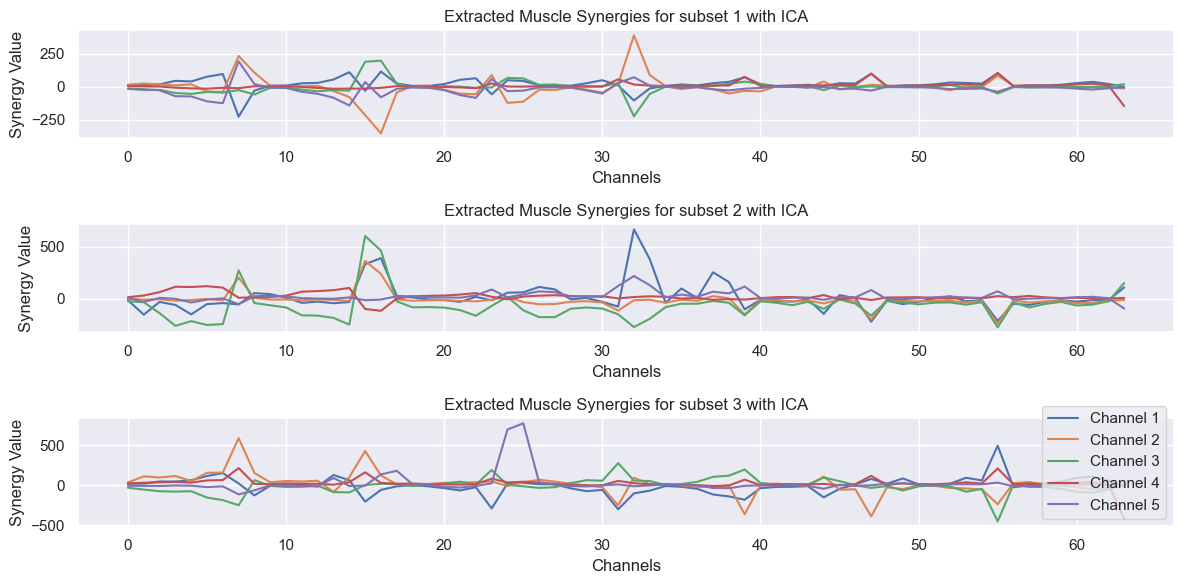

In [179]:
# Plot extracted synergies
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(H1_ICA.T)
plt.title('Extracted Muscle Synergies for subset 1 with ICA')
plt.xlabel('Channels')
plt.ylabel('Synergy Value')

plt.subplot(3, 1, 2)
plt.plot(H2_ICA.T)
plt.title('Extracted Muscle Synergies for subset 2 with ICA')
plt.xlabel('Channels')
plt.ylabel('Synergy Value')

plt.subplot(3, 1, 3)
plt.plot(H3_ICA.T)
plt.title('Extracted Muscle Synergies for subset 3 with ICA')
plt.xlabel('Channels')
plt.ylabel('Synergy Value')
plt.legend(['Channel 1', 'Channel 2', 'Channel 3', 'Channel 4', 'Channel 5'])

plt.tight_layout()

#plt.savefig('ICA')

In [137]:
((H2_ICA.T)[:,0]).shape

(64,)

In [135]:
correlation_coefficient = np.corrcoef((H1_ICA.T)[:,0], (H2_ICA.T)[:,0])[0, 1]

In [136]:
print(correlation_coefficient)

-0.2648936364466882


In [141]:
correlation_coefficient = np.corrcoef((H1_PCA.T)[:,4], (H2_PCA.T)[:,4])[0, 1]
print(correlation_coefficient)

0.23650362716531986


In [173]:
correlation_coefficient_PCA12 = []
correlation_coefficient_PCA13 = []
correlation_coefficient_PCA32 = []
for i in range(0,5):
    correlation_coefficient_PCA12.append(np.corrcoef((H1_PCA.T)[:,i], (H2_PCA.T)[:,i])[0, 1])
    correlation_coefficient_PCA13.append(np.corrcoef((H1_PCA.T)[:,i], (H3_PCA.T)[:,i])[0, 1])
    correlation_coefficient_PCA32.append(np.corrcoef((H3_PCA.T)[:,i], (H2_PCA.T)[:,i])[0, 1])

In [174]:
correlation_coefficient_ICA12 = []
correlation_coefficient_ICA13 = []
correlation_coefficient_ICA32 = []
for i in range(0,5):
    correlation_coefficient_ICA12.append(np.corrcoef((H1_ICA.T)[:,i], (H2_ICA.T)[:,i])[0, 1])
    correlation_coefficient_ICA13.append(np.corrcoef((H1_ICA.T)[:,i], (H3_ICA.T)[:,i])[0, 1])
    correlation_coefficient_ICA32.append(np.corrcoef((H3_ICA.T)[:,i], (H2_ICA.T)[:,i])[0, 1])

In [175]:
correlation_coefficient_NMF12 = []
correlation_coefficient_NMF13 = []
correlation_coefficient_NMF32 = []
for i in range(0,5):
    correlation_coefficient_NMF12.append(np.corrcoef((H1_NMF.T)[:,i], (H2_NMF.T)[:,i])[0, 1])
    correlation_coefficient_NMF13.append(np.corrcoef((H1_NMF.T)[:,i], (H3_NMF.T)[:,i])[0, 1])
    correlation_coefficient_NMF32.append(np.corrcoef((H3_NMF.T)[:,i], (H2_NMF.T)[:,i])[0, 1])

In [176]:
print('NMF')
correlation_coefficient_NMF12 = [round(number, 3) for number in correlation_coefficient_NMF12]
correlation_coefficient_NMF13 = [round(number, 3) for number in correlation_coefficient_NMF13]
correlation_coefficient_NMF32 = [round(number, 3) for number in correlation_coefficient_NMF32]
print('subset 1-2 :',correlation_coefficient_NMF12)
print('subset 1-3 :',correlation_coefficient_NMF13)
print('subset 2-3: ', correlation_coefficient_NMF32)

NMF
subset 1-2 : [0.256, -0.308, -0.094, 0.164, -0.287]
subset 1-3 : [-0.026, 0.827, -0.248, -0.249, -0.16]
subset 2-3:  [-0.029, -0.474, -0.058, 0.378, 0.137]


In [177]:
print('ICA')
correlation_coefficient_ICA12 = [round(number, 3) for number in correlation_coefficient_ICA12]
correlation_coefficient_ICA13 = [round(number, 3) for number in correlation_coefficient_ICA13]
correlation_coefficient_ICA32 = [round(number, 3) for number in correlation_coefficient_ICA32]
print('subset 1-2 :',correlation_coefficient_ICA12)
print('subset 1-3 :',correlation_coefficient_ICA13)
print('subset 2-3 :', correlation_coefficient_ICA32)

ICA
subset 1-2 : [-0.265, -0.324, 0.73, -0.164, 0.168]
subset 1-3 : [0.352, 0.047, 0.195, 0.716, -0.135]
subset 2-3 : [-0.363, 0.796, 0.099, -0.028, 0.04]


In [178]:
print('PCA')
correlation_coefficient_PCA12 = [round(number, 3) for number in correlation_coefficient_PCA12]
correlation_coefficient_PCA13 = [round(number, 3) for number in correlation_coefficient_PCA13]
correlation_coefficient_PCA32 = [round(number, 3) for number in correlation_coefficient_PCA32]

print('subset 1-2 :',correlation_coefficient_PCA12)
print('subset 1-3 :',correlation_coefficient_PCA13)
print('subset 2-3 :', correlation_coefficient_PCA32)

PCA
subset 1-2 : [0.671, -0.559, 0.724, -0.184, 0.237]
subset 1-3 : [0.649, 0.504, 0.282, -0.276, -0.005]
subset 2-3 : [0.965, -0.894, 0.308, -0.005, 0.081]
